# DACON - 자율주행 센서의 안테나 성능 예측 AI 경진대회

### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

### Data Load

In [90]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train.shape, test.shape

((39607, 71), (39608, 57))

### EDA and Preprocessing
#### Missing Value

In [91]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

#### Feature Engineering

In [92]:
feature_x_idx = 56

In [93]:
feature_col_list = train.iloc[:, :feature_x_idx+1].columns.tolist()
feature_col_list.remove("ID")
len(feature_col_list)

56

In [94]:
target_col_list = train.iloc[:, feature_x_idx+1:].columns.tolist()
len(target_col_list)

14

##### Check Outlier

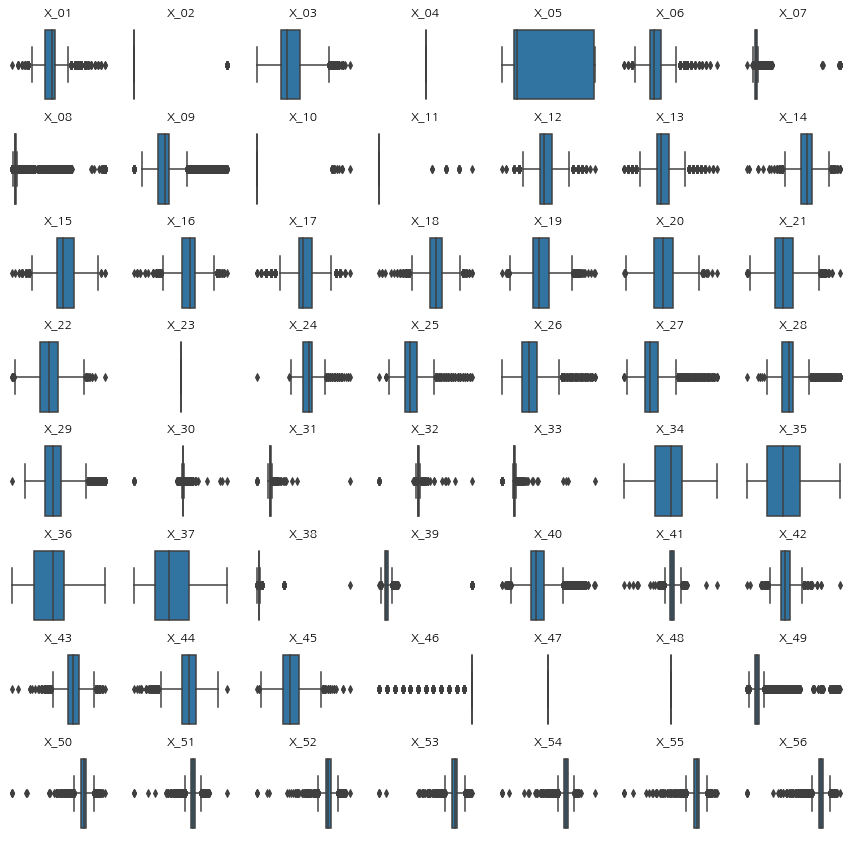

In [95]:
plt.figure(figsize=(15, 15))
for idx in range(len(feature_col_list)):
    plt.subplot(8, 7, idx+1)
    sns.boxplot(data=train, x=feature_col_list[idx]).set_title(str(feature_col_list[idx]))
    plt.axis("off")
plt.show()

In [96]:
def get_outlier(df=None, col=None, weight=1.5):
    fraud = df[col]
    q25 = np.percentile(fraud.values, 25)
    q75 = np.percentile(fraud.values, 75)
    iqr = q75-q25
    iqr_weight = iqr*weight
    lowest_val = q25 - iqr_weight
    higest_val = q75 + iqr_weight
    outlier_index = fraud[(fraud<lowest_val) | (fraud>higest_val)].index
    return outlier_index

In [97]:
for feature in feature_col_list:
    replace_outlier_h = train[feature].describe()["75%"]
    replace_outlier_l = train[feature].describe()["25%"]
    for idx in get_outlier(train, feature):
        train.loc[idx, feature] = replace_outlier_l if train.loc[idx, feature]<replace_outlier_l else replace_outlier_h

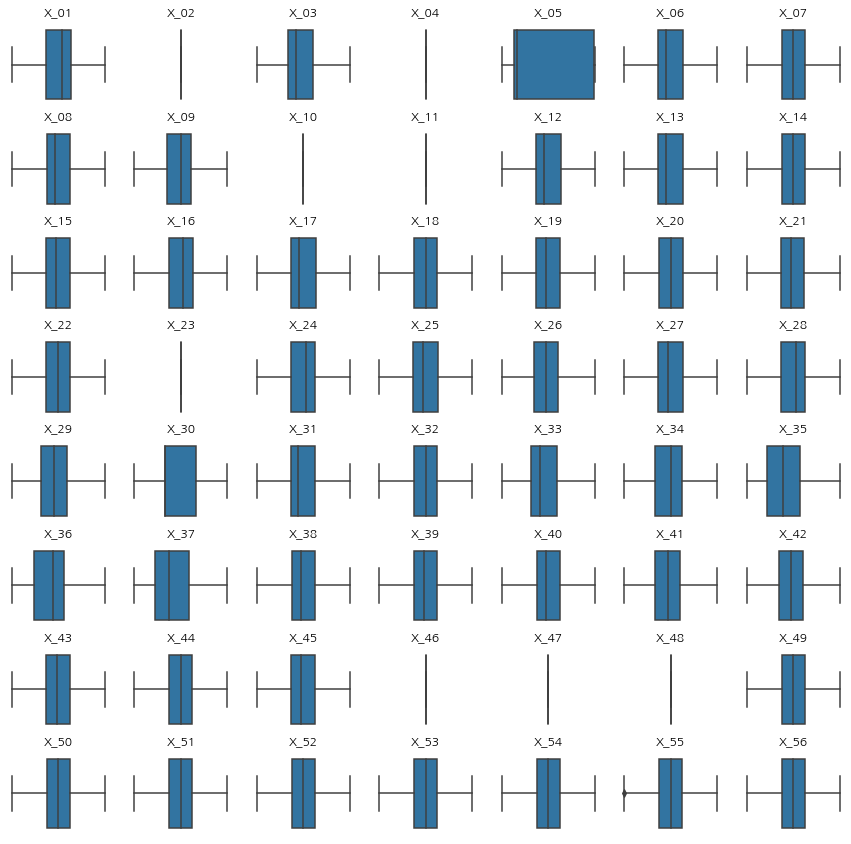

In [98]:
plt.figure(figsize=(15, 15))
for idx in range(len(feature_col_list)):
    plt.subplot(8, 7, idx+1)
    sns.boxplot(data=train, x=feature_col_list[idx]).set_title(str(feature_col_list[idx]))
    plt.axis("off")
plt.show()

### Train and Predict

In [99]:
x_train, x_val, y_train, y_val = train_test_split(train[feature_col_list], train[target_col_list], test_size=0.2)

print(f"x_trian: {x_train.shape}\ny_train: {y_train.shape}\nx_val: {x_val.shape}\ny_val: {y_val.shape}")

x_trian: (31685, 56)
y_train: (31685, 14)
x_val: (7922, 56)
y_val: (7922, 14)


#### RF

In [100]:
reg_rf = RandomForestRegressor()

reg_rf.fit(x_train, y_train)

pred_rf = reg_rf.predict(x_val)

np.sqrt(mean_squared_error(y_val, pred_rf))

1.1984515502744788

#### XGBoost

In [101]:
reg_xgb = xgb.XGBRegressor()

reg_xgb.fit(x_train, y_train)

pred_xgb = reg_xgb.predict(x_val)

np.sqrt(mean_squared_error(y_val, pred_xgb))

1.2363091030464417

### Submission

In [103]:
sub = pd.read_csv("./data/sample_submission.csv")

sub.head()

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
sub_pred_rf = reg_rf.predict(test[feature_col_list])
sub.iloc[:, 1:] = sub_pred_rf
sub.to_csv("./sub_rf_rmse_1_19_wo_remove_outlier_test.csv", index=False)

In [115]:
sub_pred_xgb = reg_xgb.predict(test[feature_col_list])
sub.iloc[:, 1:] = sub_pred_xgb
sub.to_csv("./sub_xgb_rmse_1_23_wo_remove_outlier_test.csv", index=False)

TODO: Test에서 아웃라이어 제거하기